In [52]:
import pandas as pd 
import numpy as np 
import importlib
import matplotlib.pyplot as plt
from processinggps import *
import numpy as np
from scipy.signal import fftconvolve

[Ephémérides](https://cddis.nasa.gov/archive/gnss/data/daily/2025/001/25n/)

# Paramètres caractéristiques

In [53]:
# Nfd nombre de fréquences Doppler
Nfd = 401
# fdmax Hz Fréquence Doppler maximale
fdmax = 5000
# fs : Fréquence d'échantillonage du signal en bande de base
fs = 2600000
# fsca : fréquence pour le débit chip
fsca = 1.023e6
# Copnstruction de la base de fréquence Doppler
fd = np.linspace(-1,1,Nfd)* (fdmax/fs)
filename='gpssim.bin'

# Lecture données

On reconstruit l'échantillon complexe en bande de base à partir de la lecture du fichier binaire

In [54]:
data = np.fromfile(filename,dtype=np.byte)
# Mise en forme complexe des échantillons I et Q
re=data[0::2]
im = data[1::2]
r = re+1j*im

In [55]:
N = r.shape[0]
T = N/fs
print('Durée du signal généré :',T,' secondes')
print('Nombre de bits à démoduler :',int(np.round(T*50)))
print('Nombre d"échantillons d"un code C/A:',int(np.round(1e-3*fs)))

Durée du signal généré : 299.9  secondes
Nombre de bits à démoduler : 14995
Nombre d"échantillons d"un code C/A: 2600


In [56]:
T_10bits = 200e-3
N_10bits = int(T_10bits*fs)
print(N_10bits)

520000


In [57]:
N_1bit=int(20*fs*1e-3)
print('N_1bit')

N_1bit


In [58]:
# Récupération de 20 ms = 10 bits 
# 1 ms  = 1 code C/A     2600
# 20 ms = 1 bit          52000 ech   
# 200 ms = 10 bits       520000 ech 

In [59]:
data = np.fromfile(filename,dtype=np.byte,count=N_10bits*2)
re=data[0::2]
im = data[1::2]
r10bits = re+1j*im

# Identification des satellites présents dans le signal reçu

In [10]:
#csat8 = codesat(8,repeatno=1)
detected_satellites,correlations,larg = identify_satellites(r10bits,fd,repeatno=20)


Le paramètre `larg`est une liste d'entiers indiquant les valeurs de décallage obtenues pour la fréquence Doppler et le code C/A

In [11]:
larg

[(204, 1522),
 (168, 84),
 (248, 9989),
 (350, 2058),
 (53, 2211),
 (110, 2300),
 (284, 29),
 (343, 2527),
 (131, 422),
 (156, 404),
 (291, 13417),
 (319, 809)]

In [12]:
csat1 = codesat(1,repeatno=20)
U=correlate2(r10bits[0:len(csat1)],csat1,fd)

In [62]:
np.where(np.abs(U)==np.max(np.abs(U)))

(array([204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204,
        204, 204, 204, 204]),
 array([ 1522,  4122,  6722, 11922, 14522, 17122, 19722, 22322, 30122,
        32722, 35322, 37922, 40522, 43122, 45722, 48322, 50922]))

In [75]:
1522+np.arange(0,22)*2600

array([ 1522,  4122,  6722,  9322, 11922, 14522, 17122, 19722, 22322,
       24922, 27522, 30122, 32722, 35322, 37922, 40522, 43122, 45722,
       48322, 50922, 53522, 56122])

(-0.5, 99.5, 7.5, -0.5)

<Figure size 2000x500 with 0 Axes>

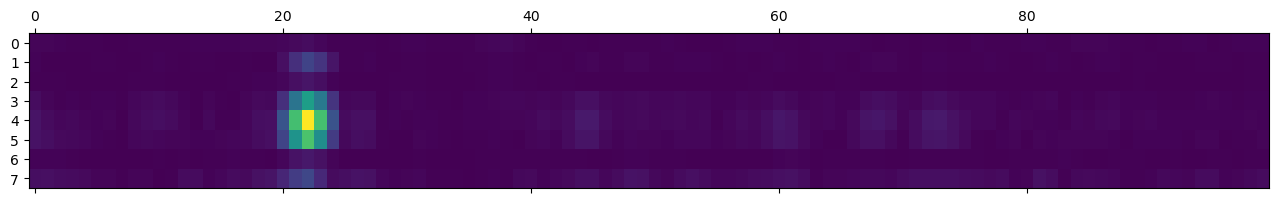

In [73]:
plt.figure(figsize=(20,5))
plt.matshow(np.abs(U[200:208,1500:1600]))
plt.axis('auto')

In [32]:
np.max(np.abs(U))

696485.6998331568

Ici on implémente une fonction qui calcule le cumul de l'intercorrélation à partir des valeurs estimées des décalages Doppler et code C/A. Pour le satellite 1 on obtient les valeurs 204 et 1522

In [10]:
offset = 1522
csat1 = codesat(1,repeatno=1)
tC = np.array([])
k=0
s,C=correlate(r[offset+k*len(csat1):(k+1)*len(csat1)+offset],csat1,fd,204,0)
    

In [11]:
print(np.abs(C))

35926.423053488164


In [61]:
x0=np.array([3.84515384615385e-05,0])
offset = 1522

In [46]:
imin = offset+30000*len(csat1)
imax = (30000+1)*len(csat1)+offset
print(imin,imax)
sig=r[imin:imax]
print(sig.shape)
#minimize(gps.correlate_fine, x0,args=(sig,csat1))

1560001522 1560053522
(0,)


In [49]:
N=len(r)

In [51]:
(N/2600)/20

14995.0

### 

In [14]:
from scipy.optimize import minimize

In [82]:
istart = 0
istop  = len(r)-len(csat1)
Nstep  = int((istop-istart)/2600)

In [86]:
index = np.arange(istart,istop,Nstep/10).astype(int)

In [92]:
index

array([        0,     29989,     59979, ..., 779647430, 779677420,
       779707410])

In [ ]:
try:
    del(tx)
except:
    pass
csat1 = codesat(1,repeatno=20)
x0=np.array([3.84515384615385e-05,0])
for k in index:
    #print(k)
    result = minimize(gps.correlate_fine, x0,args=(r[offset+k:offset+k+len(csat1)],csat1))
    try:
        tx = np.vstack((tx,result.x[None,:]))
    except:
        tx = result.x[None,:]
    x0 = result.x

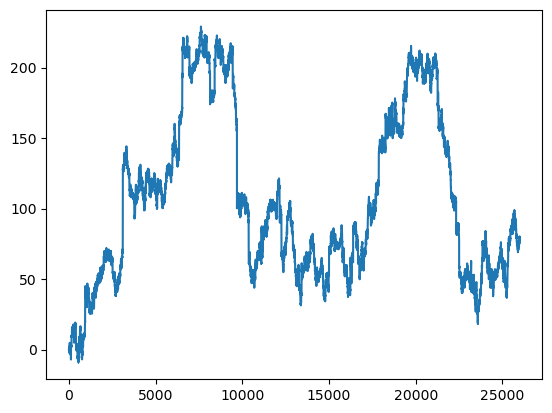

In [95]:
plt.plot(tx[:,0])

In [76]:
range(0,779740000,10000)

range(0, 779740000, 10000)

In [89]:
import processinggps as gps
importlib.reload(gps)

<module 'processinggps' from '/home/uguen/ens/cours/master/gps_sdr_sim/processinggps.py'>

In [39]:
C=gps.correlate_fine(x,r[offset+k*len(csat1):(k+1)*len(csat1)+offset],csat1)

In [40]:
print(np.abs(C))

35926.46002598269


In [186]:
np.sum(shift_signal_hermitian(csat1,4.3)**2)

2599.773439366358

In [187]:
np.sum(csat1**2)

2600

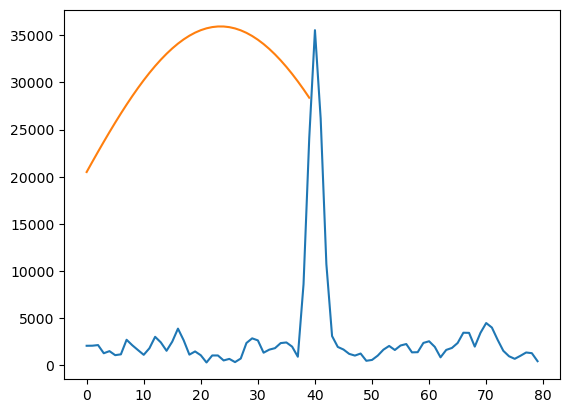

In [162]:
plt.plot(tC[20,:])
plt.plot(tC[:,40])

35926.423053488164


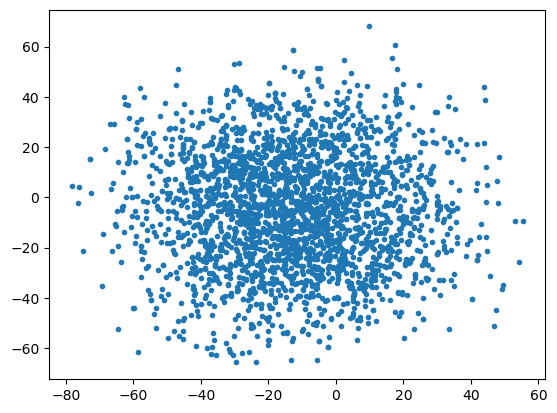

In [137]:
sc = s * csat1
print(np.abs(np.sum(sc)))
plt.plot(np.real(sc),np.imag(sc),'.')

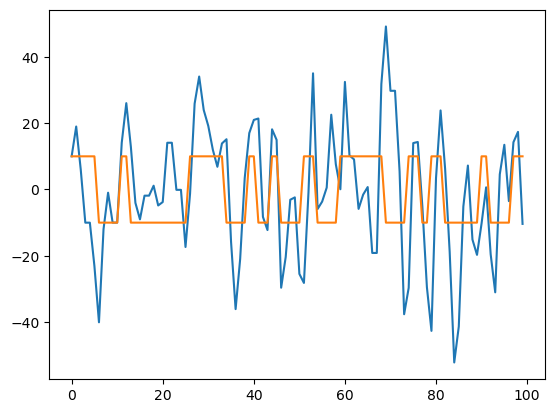

In [109]:
plt.plot(np.real(s[0:100]))
plt.plot(10*np.real(csat1[0:100]))

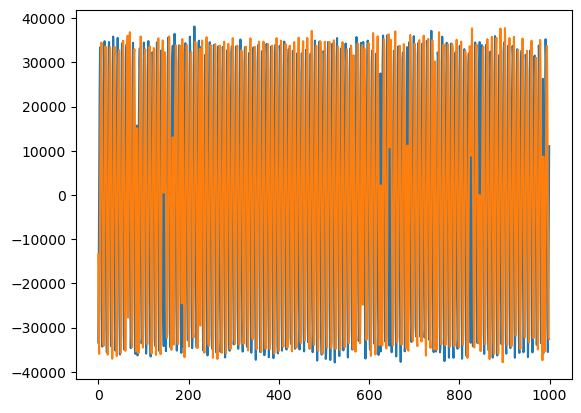

In [110]:
plt.plot(np.real(tC))
plt.plot(np.imag(tC))

In [47]:
rc = r10bits[0:len(csat1)]
Nc = len(rc)
t  = np.arange(0,Nc) 
f  = np.linspace(0,1,Nc) 
CD = np.fft.fft(csat1)*np.exp(1j*2*np.pi*f*np.sign(1/2-f)*1522/Nc)
cd = np.fft.ifft(CD)



In [52]:
csat1_dec=np.roll(csat1,1526)
CSAT1_DEC = np.fft.fft(csat1_dec)
CSAT1 = np.fft.fft(csat1)

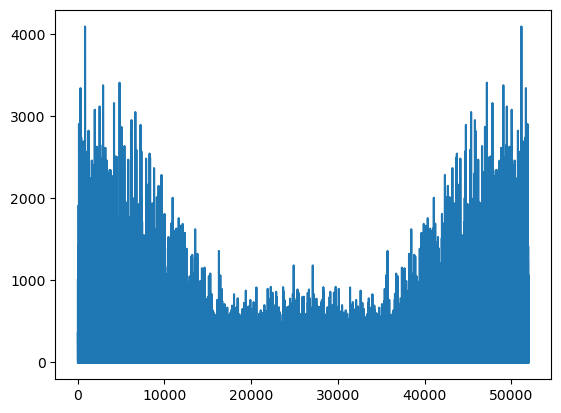

In [60]:
plt.plot(np.abs(CSAT1_DEC))

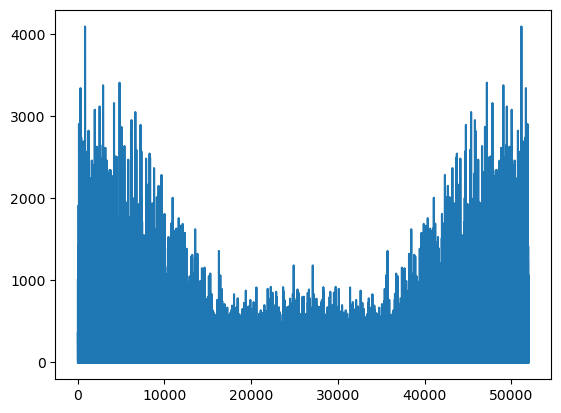

In [63]:
plt.plot(np.abs(CSAT1))

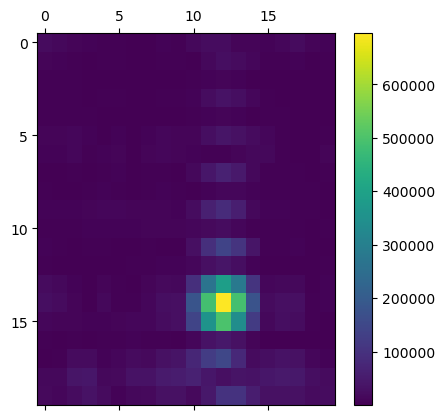

In [11]:
plt.matshow(np.abs(U[190:210,1510:1530]))
plt.axis('auto')
plt.colorbar()

Text(0, 0.5, 'Correlation value')

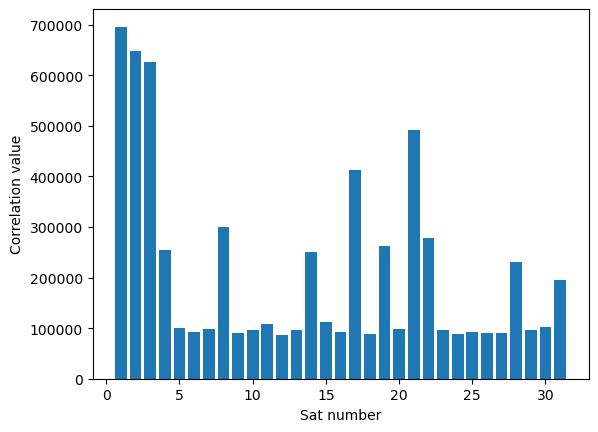

In [11]:
plt.bar(np.arange(1,32),correlations)
plt.xlabel('Sat number')
plt.ylabel('Correlation value')

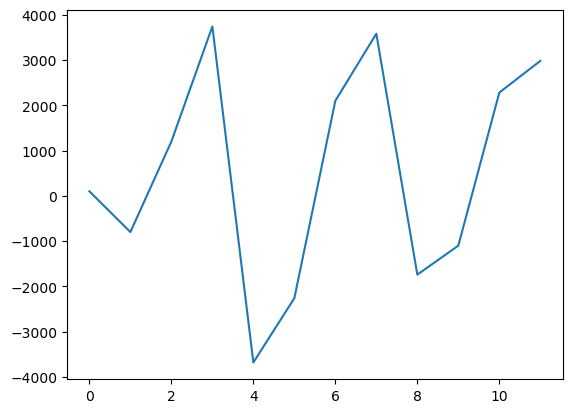

In [26]:
plt.plot(fd[np.array(larg)[:,0]]*fs)

In [268]:
correlations = []
lfineDoppler =[]
for k,sat_num in enumerate(detected_satellites):
    csat = codesat(sat_num,repeatno=20)
    idxfdsat = larg[k][0]
    fdsat  = np.linspace(fd[idxfdsat-1],fd[idxfdsat+1],Nfd)
    rc = r[0:len(csat)]
    U = correlate(rc,csat,fdsat)
    corrmax = np.max(np.abs(U))
    a = np.where(np.abs(U)==corrmax)
    correlations.append(corrmax)
    lfineDoppler.append(fdsat[a[0][0]])

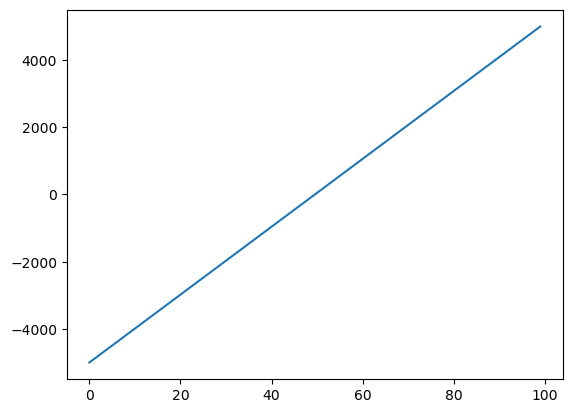

In [37]:
plt.plot(fd*fs)

In [269]:
lfineDoppler

[-0.0014152794455824758,
 -0.0008690243538728386,
 0.0008054515630273209,
 0.0013748597081930417,
 -0.0006669256669256669,
 0.0008729486002213278,
 0.0011472534199806932]

In [105]:
csat8.shape

(2600,)

In [106]:
r.shape

(520000,)

In [27]:
csat8 = codesat(8,repeatno=20)
U=correlate2(r10bits[0:len(csat8)],csat8,fd)

Maximum de la corrélation 2D 

In [36]:
U.shape

(100, 52000)

In [34]:
np.where(np.abs(U)==np.max(np.abs(U)))

(array([13, 13]), array([ 7411, 28211]))

(-0.5, 49.5, 99.5, -0.5)

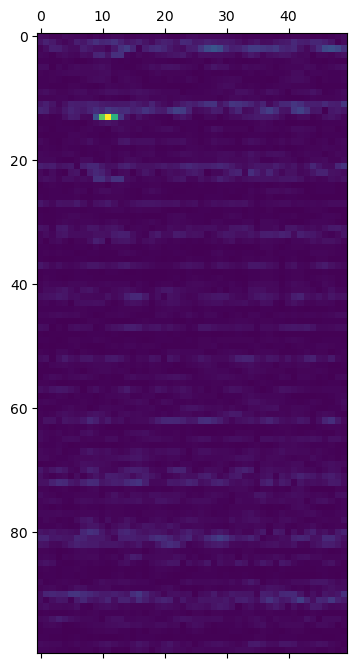

In [35]:
plt.matshow(np.abs(U[:,7400:7450]))
plt.axis('auto')

In [28]:
np.max(np.abs(U))

294529.5373466032

In [131]:

corrmax = np.max(np.abs(U))
a = np.where(np.abs(U)==corrmax)

(-0.5, 2599.5, 99.5, -0.5)

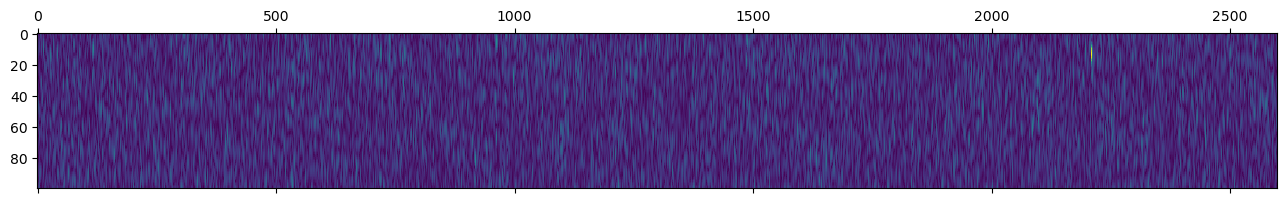

In [137]:
plt.matshow(np.abs(U),interpolation='none')
plt.axis('auto')

In [111]:
rrcode1 = r[0:2600]*np.exp(2*1j*np.pi*fd[13])*np.roll(csat8,2211)
rrcode2 = r[0:2600]*np.exp(2*1j*np.pi*fd[13])*np.roll(csat8,2210)

In [161]:
a

(array([51, 51, 51, 51, 51, 51, 51, 51, 51, 51]),
 array([  809,  6009, 16409, 19009, 21609, 24209, 32009, 34609, 45009,
        47609]))

In [98]:
len(rrcode1)/2600

20.0

In [278]:
tab = np.array([])
for k in range(10):
    t  = np.arange(52000)
    sig = r[k*52000:(k+1)*52000]*np.exp(-2*1j*np.pi*lfineDoppler[0]*t)*np.roll(csat,7411)
    tab = np.append(tab,np.sum(sig))

/home/uguen/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/uguen/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


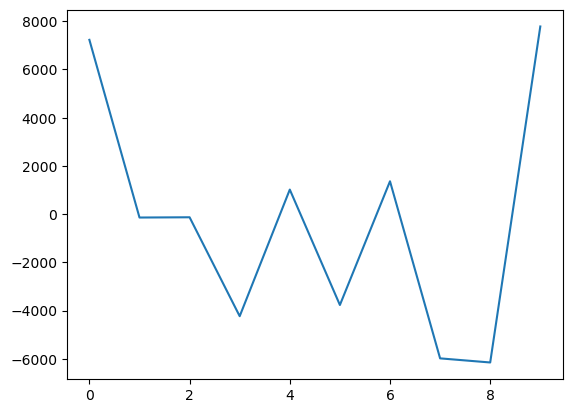

In [279]:
plt.plot(np.real(tab))
plt.plot(np.im

In [275]:
tab = np.array([])
for k in range(10):
    t  = np.arange(52000)
    RR   = np.fft.fft(r[k*52000:(k+1)*52000])**np.exp(-2*1j*np.pi*lfineDoppler[0]*t)
    CSAT = np.fft.fft(csat*np.exp(-2*1j*7411/52000))
    U   = np.fft.ifft(RR*np.conj(CSAT))
    corrmax = np.max(np.abs(U))
    tab = np.append(tab,corrmax)

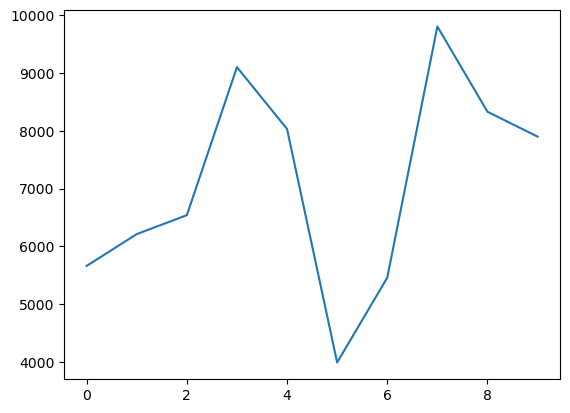

In [276]:
plt.plot(np.arange(10),np.real(tab))


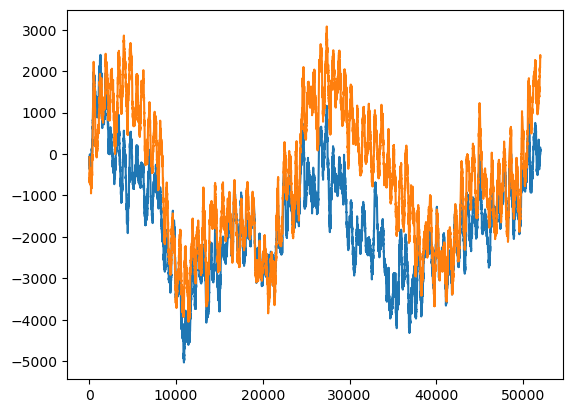

In [91]:
plt.plot(np.cumsum(rrcode1))
plt.plot(np.cumsum(rrcode2))

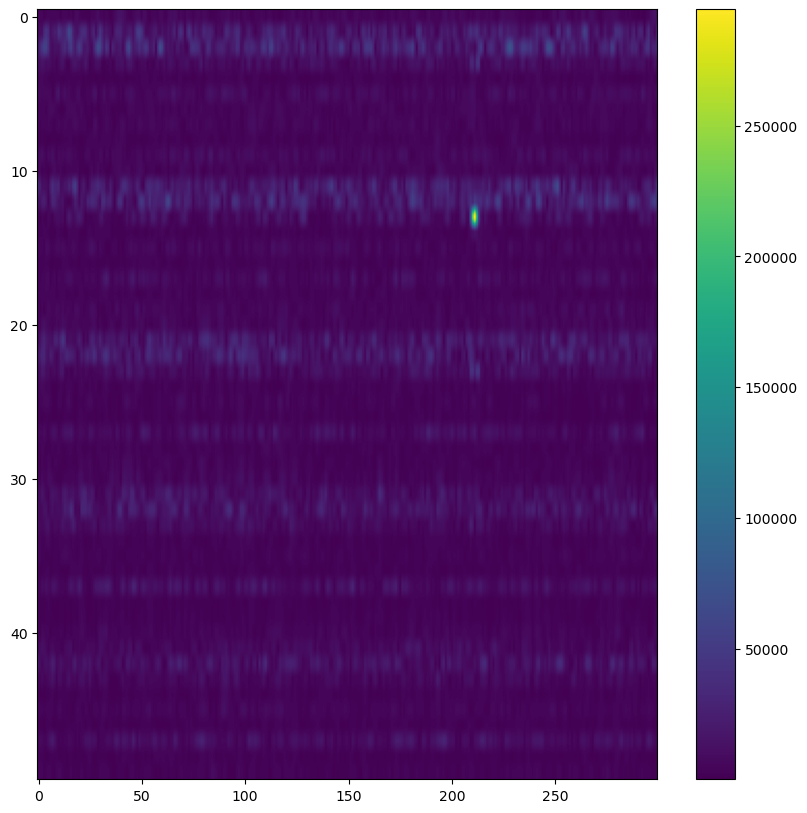

In [76]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(U[0:50,7200:7500]))
plt.axis('auto')
plt.colorbar()

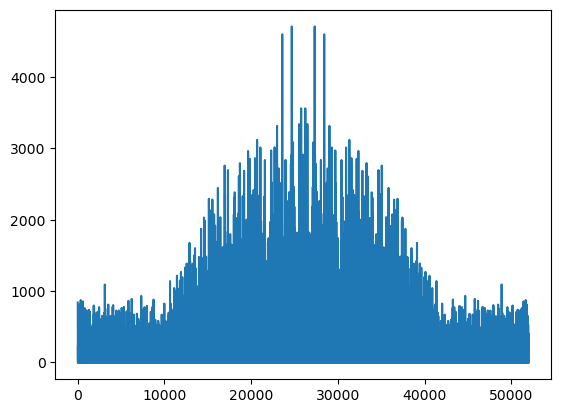

In [35]:
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(csat8))))

In [20]:
for k,kstart in enumerate(np.linspace(0,len(r)-len(csat),30).astype(int)):
    lfineDoppler,fdoppcorr = fine_Doppler(r,detected_satellites,fd,larg,kstart=kstart)
    try: 
        tfDoppler = np.hstack((tfDoppler,np.array(lfineDoppler)[None,:]))
    except:
        tfDoppler = np.array(lfineDoppler)[None,:]

NameError: name 'csat' is not defined

In [70]:
tfDoppler = tfDoppler[70:]

In [71]:
A = tfDoppler.reshape(30,7).T

ValueError: cannot reshape array of size 0 into shape (30,7)

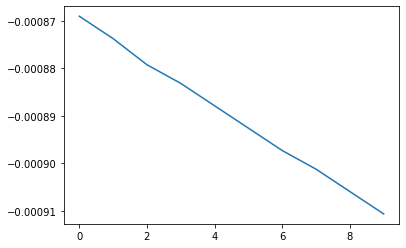

In [64]:
plt.plot(A[1,:])

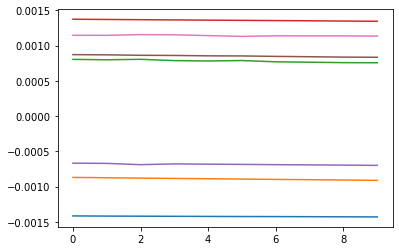

In [62]:
for isat in np.arange(7):
    plt.plot(A[isat,:])

In [44]:
csat = codesat(8,repeatno=20)

In [48]:
len(r)/10

77974000.0

In [45]:
len(csat)

52000

In [39]:
lfineDoppler

[-0.0014152794455824758,
 -0.0008690243538728386,
 0.0008054515630273209,
 0.0013748597081930417,
 -0.0006669256669256669,
 0.0008729486002213278,
 0.0011472534199806932]

In [41]:
fd[13]

-0.0014180264180264181

In [ ]:
# Initialisation des paramètres
frequency_doppler = initial_doppler
code_shift = initial_code_shift

# Boucle de suivi
for sample in signal:
    # Appliquer le décalage du code et la compensation Doppler
    synchronized_signal = apply_doppler_and_code_shift(signal, code_shift, frequency_doppler)
    
    # Calculer les corrélations early, on-time, late
    correlation_early = calculate_correlation(synchronized_signal, early_code_samples)
    correlation_on_time = calculate_correlation(synchronized_signal, on_time_code_samples)
    correlation_late = calculate_correlation(synchronized_signal, late_code_samples)
    
    # Mettre à jour la fréquence Doppler et le décalage du code
    frequency_doppler, code_shift = update_tracking(correlation_early, correlation_on_time, correlation_late, frequency_doppler, code_shift)
    
    # Utiliser frequency_doppler et code_shift pour ajuster le signal et extraire les données


In [61]:
s = np.array([ 1786,  4386,  6986,  9586, 12186, 14786, 17386, 22586, 25186,27786, 32986, 38186, 43386, 48586])

In [62]:
s[1:]-s[0:-1]

array([2600, 2600, 2600, 2600, 2600, 2600, 5200, 2600, 2600, 5200, 5200,
       5200, 5200])

In [58]:
larg[1:3]

[(array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]),
  array([ 1786,  4386,  6986,  9586, 12186, 14786, 17386, 22586, 25186,
         27786, 32986, 38186, 43386, 48586])),
 (array([62, 62, 62]), array([ 2189,  7389, 17789]))]

In [ ]:
# Fonction pour synchroniser le signal sur un satellite particulier
def synchronize_signal(signal, code, doppler_shift):
    # Compenser le décalage du code
    synchronized_signal = np.roll(signal, -offset)
    # Appliquer la compensation Doppler
    # Vous pouvez utiliser une fonction de compensation Doppler appropriée ici
    return synchronized_signal

# Fonction pour extraire la séquence binaire d'un signal synchronisé
def extract_binary_sequence(synchronized_signal, code_length):
    # Implémentez votre méthode d'extraction de séquence binaire ici
    pass

# Paramètres
num_satellites = 32
code_length = 1023  # Longueur du code C/A
doppler_shift = 0   # Décalage Doppler initial (à adapter)

# Exemple de signal GPS
signal_I = np.random.rand(10000)  # Échantillon I du signal
signal_Q = np.random.rand(10000)  # Échantillon Q du signal

# Identifier les satellites présents dans le signal
detected_satellites = identify_satellites(signal_I + 1j * signal_Q, code_length)

# Synchroniser et extraire la séquence binaire pour chaque satellite détecté
for satellite_num in detected_satellites:
    code = generate_CA_code(satellite_num)
    synchronized_signal = synchronize_signal(signal_I + 1j * signal_Q, code, doppler_shift)
    binary_sequence = extract_binary_sequence(synchronized_signal, code_length)
    print(f"Satellite {satellite_num}: Binary sequence {binary_sequence}")


In [7]:
!ls

 2019_12_13_433_MS1	  GPS-LOR1-1-10-2020    processinggps.py
 2019_12_13_433_MS2	  GPSManip	        __pycache__
 2019_12_13_GPS_SB1	  gps.py	        read_data1.py
 2019_12_13_GPS_SB2	  gpssim.bin	        read_data2.py
 2019_12_INSA_1.zip	  ipython_log.py        read_data3.py
 2019_12_INSA_2.zip	  LABSTIC-GPS	        read_data.py
 brdc0180.24n		  logSB1.txt	        tmp
 DemodulationGPS2.ipynb   logSB2.txt
 DemodulationGPS.ipynb	 'pièces jointes.zip'


# Lecture Fichier GPS en bande de bae

$r$ est le signal complex reçu

In [4]:
fs = 2600000     # frequence d'échantillonage
fsca = 1.023e6   # fréquence chip 1MHz
#t = np.linspace(0,len(r)/fs,len(r))  # base de temps signal

In [23]:
300*fs-len(r)

260000

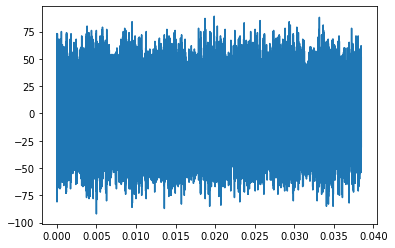

In [14]:
plt.plot(t[0:100000],re[0:100000])

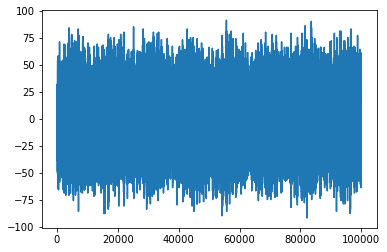

In [39]:
plt.plot(im[0:100000])

In [17]:
Nfd = 100
fdmax = 5000
fs = 2600000

Creation d'une plage d'exploration Doppler

In [77]:
sat = np.array( PRN(1) ) 
satind  =  np.floor( np.linspace(0, len(sat)-1, num=int((fs/fsca)* len(sat)) )     ).astype(int)

In [79]:
satrep=sat[satind]

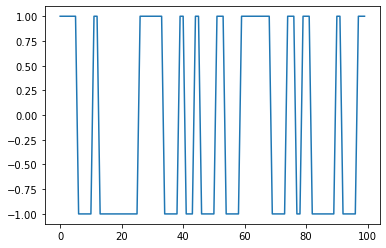

In [83]:
plt.plot(satrep[0:100])

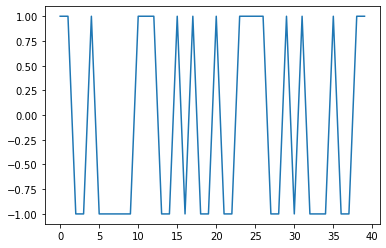

In [85]:
plt.plot(sat[0:40])

In [18]:
fd = np.linspace(-1,1,Nfd)* (fdmax/fs)

In [5]:
fd = np.linspace(-3800/fs,-3500/fs,100)

In [22]:
fd[14]*fs

-3585.8585858585857

In [99]:
tu = []
for isat in range( 8 ,  9 ):
    sat = np.array( PRN(isat) ) # code PRN du satellite
    repeatno= 20
    satind  =  np.floor( np.linspace(0, len(sat)-1, num=int((fs/fsca)* len(sat)) )     ).astype(int)
    satrep  = sat[satind]
    csat = np.tile(satrep,repeatno)
    if  len(csat)  >  len(r) :
        csat = csat[0:len(r)]

    rc = r[0:len(csat)]
    t = np.arange(0,len(rc) )

    rr = rc[None,:]*np.exp(-1j*2*np.pi*t[None,:]*fd[:,None])
    YE = np.fft.fft(rr,axis= 1)

    CSAT = np.fft.fft(csat)

    U = np.fft.ifft(YE* np.conj(CSAT[None,:]),axis= 1)
    tu.append(np.max(np.abs(U)))
    #print(isat,)
    #plt.figure('GPS number = ' + str(isat),figsize=(20,20))
    #plt.subplot(211)
    #plt.title('GPS number = ' + str(isat))
    #plt.imshow(np.abs(U)     ,cmap='jet') #  , vmin =  0 ,  vmax= 30
    #plt.axis('auto')
    #plt.colorbar()
    #plt.show()

# Satellite N°8

In [33]:
csat = bitsat(8)
rc1 = r[0:len(csat)]
rc2 = r[len(csat):2*len(csat)]
t = np.arange(0,len(rc1) )

In [34]:
Y1=correlate(rc1,bitsat(8),fd)

In [35]:
Y2=correlate(rc2,bitsat(8),fd)

In [40]:
u1 = np.where(np.abs(Y1)>np.max(np.abs(Y1))-100)

In [41]:
u2 = np.where(np.abs(Y2)>np.max(np.abs(Y2))-100)

In [43]:
u1

(array([39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]),
 array([  2211,   4811,   7411,  10011,  12611,  15211,  17811,  20411,
         23011,  25611,  28211

In [92]:
a=np.array([1,2,3,4])

In [45]:
crc1=rc1*np.exp(-1j*2*np.pi*t*fd[39])

In [48]:
len(csat)

520000

In [49]:
crc1=crc1*np.roll(csat,2211)

In [23]:
np.sum(crc1[0:2211])

(-15011.82439728486+495.3419105566158j)

In [25]:
np.sum(crc1[2211:4811])

(-16236.48066266818+2512.1426885985743j)

In [26]:
np.sum(crc1[7411:10011])

(-14054.077008980814+3507.5383650309873j)

In [27]:
np.sum(crc1[10011:12611])

(-14690.093756594077+3198.7929591495617j)

In [50]:
s = np.add.reduceat(crc1, u1[1])

In [10]:
plt.plot(np.real(s),np.imag(s))

NameError: name 's' is not defined

In [82]:
u2

(array([39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39, 39]),
 array([ 2211,  4811,  7411, 10011, 12611, 15211, 17811, 20411, 23011,
        25611, 28211, 30811, 33411, 36011, 38611, 41211, 43811, 46411,
        49011, 51611]))

(-0.5, 51999.5, 99.5, -0.5)

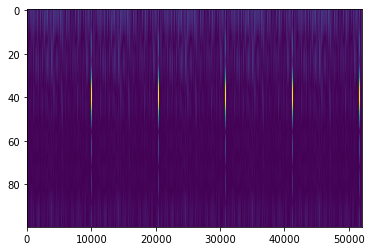

In [75]:
plt.imshow(np.abs(Y2))
plt.axis('auto')

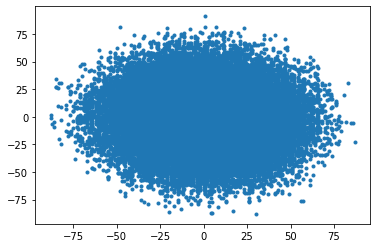

In [55]:
plt.plot(np.real(rc),np.imag(rc),'.')

In [52]:
fd[27]

-0.00143006993006993

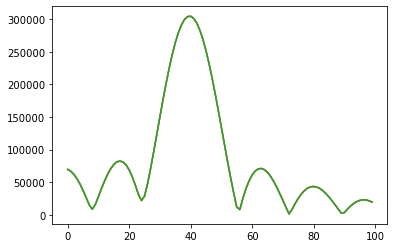

In [44]:
#plt.imshow(np.abs(Y))
plt.plot(np.abs(Y)[:,2211])
plt.plot(np.abs(Y)[:,7411])
plt.plot(np.abs(Y)[:,51611])

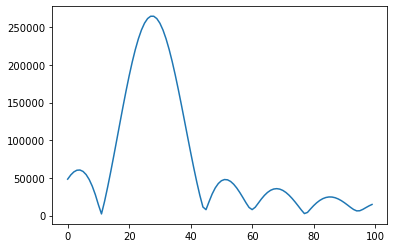

In [51]:
plt.plot(np.abs(Y)[:,17043])

In [119]:
len(bitsat(8))/fs

0.02

(array([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]),
 array([ 2211,  4811,  7411, 12611, 15211, 17811, 20411, 23011, 28211,
        30811, 33411, 38611, 41211, 43811, 49011, 51611]))

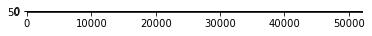

In [111]:
plt.imshow(np.abs(U),cmap='hot')

np.where(np.abs(U)==np.max(np.abs(U)))

In [112]:
U[13,2211]

(-275315.30165930296-104638.10511401236j)

In [127]:
fd[12:15]

array([-0.00145688, -0.00141803, -0.00137918])

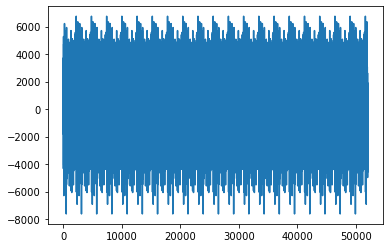

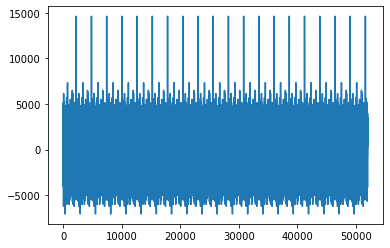

In [126]:
plt.plot(np.imag(U[14]))
plt.figure()
plt.plot(np.real(U[14]))

In [64]:
cA1=1-2*np.random.randint(0,2,1023)
cA2=1-2*np.random.randint(0,2,1023)

In [65]:
c1=PRN(1)

In [66]:
c2=PRN(2)

In [38]:
cc1=np.fft.ifft(np.fft.fft(c1)*np.conj(np.fft.fft(c1)))

In [51]:
def xcorr(c1,c2):
    cc = np.fft.ifft(np.fft.fft(c1)*np.conj(np.fft.fft(c2)))
    return(np.real(cc))

In [57]:
cc1=xcorr(c1,c1)

In [54]:
ccA=xcorr(cA,cA)

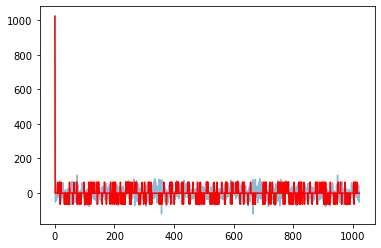

In [59]:
plt.plot(ccA,alpha=0.5)
plt.plot(cc1,'r')

In [61]:
cc1[0]=0

In [63]:
cc1

array([ 0., -1., -1., ..., -1., -1., -1.])

In [72]:
ccA12=xcorr(cA1,cA2)
cc12=xcorr(c1,c2)

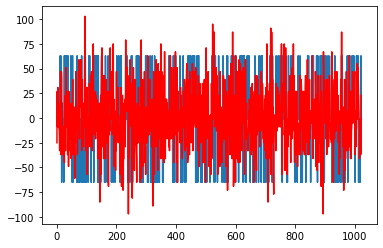

In [74]:
plt.plot(cc12)
plt.plot(ccA12,'r')

In [30]:
np.linspace(0,10,11)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [31]:
s = np.random.rand(10)

In [33]:
t=np.arange(0,len(s))

In [36]:
len(s)

10

# Mot de télémétrie

[110001011]